In [120]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [121]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [122]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [123]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [124]:
len(dataset)

68

In [1]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

NameError: name 'plt' is not defined

In [126]:
len(dataset)

68

In [127]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [128]:
train_ds=dataset.take(54)
len(train_ds)

54

In [129]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [130]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [131]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [132]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [133]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [134]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [135]:
len(train_ds)

54

In [136]:
len(val_ds)

6

In [137]:
len(test_ds)

8

In [138]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [139]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [140]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [141]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

In [142]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [143]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    )

Epoch 1/10
54/54 [==============================] - 42s 726ms/step - loss: 0.6222 - accuracy: 0.7240 - val_loss: 0.4273 - val_accuracy: 0.8177
Epoch 2/10
54/54 [==============================] - 34s 625ms/step - loss: 0.2862 - accuracy: 0.8837 - val_loss: 0.1946 - val_accuracy: 0.9167
Epoch 3/10
54/54 [==============================] - 33s 602ms/step - loss: 0.2643 - accuracy: 0.8964 - val_loss: 0.2518 - val_accuracy: 0.9115
Epoch 4/10
54/54 [==============================] - 33s 618ms/step - loss: 0.1793 - accuracy: 0.9317 - val_loss: 0.1586 - val_accuracy: 0.9323
Epoch 5/10
54/54 [==============================] - 35s 639ms/step - loss: 0.1499 - accuracy: 0.9410 - val_loss: 0.1613 - val_accuracy: 0.9375
Epoch 6/10
54/54 [==============================] - 36s 670ms/step - loss: 0.1293 - accuracy: 0.9537 - val_loss: 0.1507 - val_accuracy: 0.9323
Epoch 7/10
54/54 [==============================] - 36s 676ms/step - loss: 0.1194 - accuracy: 0.9554 - val_loss: 0.1854 - val_accuracy: 0.9479

In [144]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 154ms/step - loss: 0.1792 - accuracy: 0.9219


In [145]:
scores

[0.17921942472457886, 0.921875]

In [146]:
history

In [147]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [148]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [149]:
history.history['accuracy']

[0.7239583134651184,
 0.8836805820465088,
 0.8964120149612427,
 0.9317129850387573,
 0.9409722089767456,
 0.9537037014961243,
 0.9554398059844971,
 0.9594907164573669,
 0.9612268805503845,
 0.9681712985038757]

In [150]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validatin Accuracy')

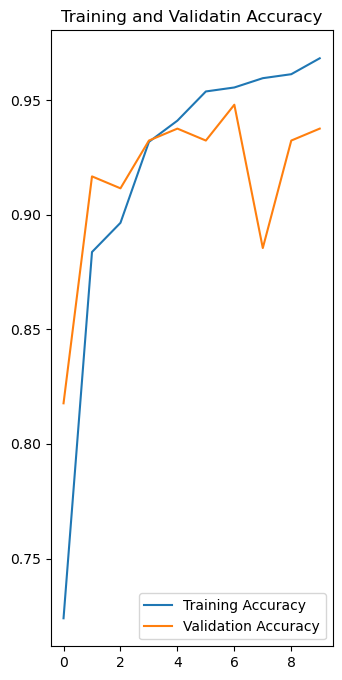

In [152]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validatin Accuracy')

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 0s 258ms/step
predicted label: Potato___Early_blight


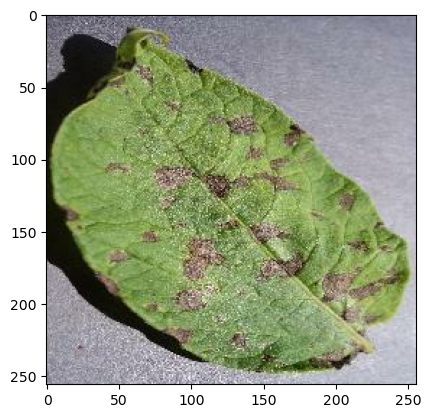

In [155]:
import numpy as np
for image_batch,label_batch in dataset.take(1):

    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [160]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)#create a batch
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 37ms/step


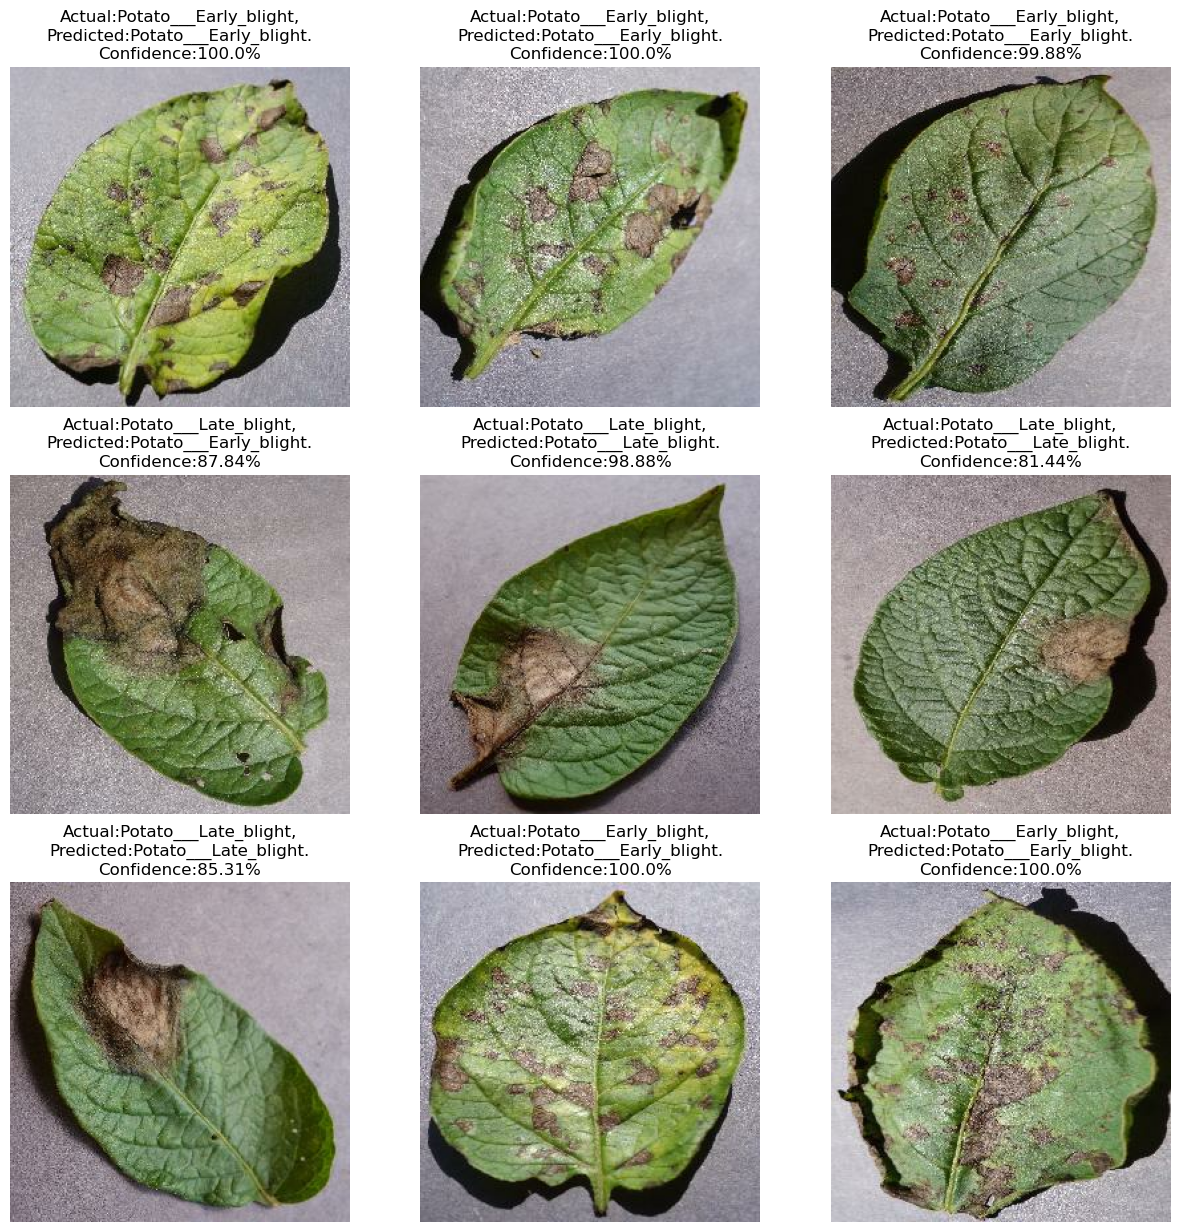

In [161]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\nPredicted:{predicted_class}.\nConfidence:{confidence}%")
        plt.axis("off")